In [4]:
# Title:    MovieLens Matrix Factorization Based Recommender (Bayesian Implicit Feedback Edition)
# Author:   Thomas M. Marshall
# Module:   Applied Machine Learning at Scale 813
# Date:     2022/03/28

# Libraries
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from matplotlib import rc
import pandas as pd
import numpy as np
import csv

# Enable TeX
rc('font', **{'size': 14, 'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [5]:
# Load dataset using pandas
ratings = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/ratings.csv')

# Reindex movies
movie = ratings['movieId'].value_counts().index
moviemap = {k:i for i, k in enumerate(movie)}
invmoviemap = {v: k for k, v in moviemap.items()}
ratings['movieId'] = ratings['movieId'].map(moviemap)

num_users = ratings.nunique()['userId']
num_items = ratings.nunique()['movieId']

In [3]:
# The objective of this is to reduce data accesses from O(n) to O(1)
threshold = 2.5

print("Starting user indexing...")
user_index = []
for m in range(1, num_users+1):
    s = ratings[ratings['userId'] == m]
    n = s['movieId'].to_numpy()
    r = s['rating'].to_numpy()
    prune = []

    # Prune ratings
    for i in range(len(r)):
        # Keep
        if (r[i] >= threshold): 
            r[i] = 1.0
        else:
            # Remove from observations otherwise
            prune.append(i)
            
    n = np.delete(n, prune)
    r = np.delete(r, prune)

    user_index.append((n, r))

print("Starting movie indexing...")
movie_index = []
for n in range(num_items):
    s = ratings[ratings['movieId'] == n]
    m = s['userId'].to_numpy()
    r = s['rating'].to_numpy()
    prune = []

    # Prune ratings
    for i in range(len(r)):
        # Keep
        if (r[i] >= threshold): 
            r[i] = 1.0
        else:
            # Remove from observations otherwise
            prune.append(i)

    m = np.delete(m, prune)
    r = np.delete(r, prune)
    
    movie_index.append((m, r))

Starting user indexing...
Starting movie indexing...


In [6]:

import pickle
"""
with open("trained_models/indices_user_100k_BI", "wb") as fp:
    pickle.dump(user_index, fp)
with open("trained_models/indices_movies_100k_BI", "wb") as fp:
    pickle.dump(movie_index, fp)
"""

user_index = []
movie_index = []

with open("trained_models/indices_user_100k_BI", "rb") as fp:
    user_index = pickle.load(fp)

with open("trained_models/indices_movies_100k_BI", "rb") as fp:
    movie_index = pickle.load(fp)


In [7]:
# Function that takes a user and a movie, produces a prediction
def predict(m, n, zm, zn, versionID):
    if(versionID == 0): # Group A
        return (dc(zm[:, m])[np.newaxis] @ dc(zn[:, n])[np.newaxis].T).ravel()[0]
    else: # Group B
        return (dc(zm[:, m])[np.newaxis] @ dc(zn[:, n])[np.newaxis].T).ravel()[0]

def SGD_BI(zm, zn, lamda, N=20, gamma = 0.01):
    errors = []
    
    for _ in range(N):
        # Calculate AUC with list of true outcomes and predicted outcomes
        # For every user
        if(_ % 1 == 0): 
            auc = 0.0

            for m in range(len(user_index)):
                n = user_index[m][0]

                # Set true values for the movies
                y = np.zeros((num_items))
                y[n] = 1.0

                y_ = np.zeros((num_items))

                # For every movie of user m
                for n_index, movie in enumerate(n):
                    # Make a prediction
                    r_hat = (zm[:, m][np.newaxis] @ zn[:, movie][np.newaxis].T).ravel()[0]
                    y_[n_index] = r_hat
                    
                # Calculate AUC
                auc += roc_auc_score(y, y_)/num_users

            print("Iteration:", _, "\tAUC:", round(auc, 4))
            errors.append(auc)

        # Stochastic gradient descent for number of times equal to num_users x num_movies
        for __ in range(len(user_index) * 100):
            # Sample the user uniformly
            user = np.random.randint(0, len(user_index))
            while((len(user_index[user][0]) < 2)): user = np.random.randint(0, len(user_index))

            # Get the random user's information
            n = user_index[user][0]

            # Sample a movie the user has seen randomly
            m_seen = np.random.randint(0, len(n))
            m_seenID = n[m_seen]

            # Sample a movie the user has not seen randomly
            m_unseenID = np.random.randint(0, len(movie_index))
            while(m_unseenID in n): m_unseenID = np.random.randint(0, len(movie_index))

            # Calculate derivatives
            xuij = zm[:, user][np.newaxis] @ zn[:, m_seenID][np.newaxis].T - zm[:, user][np.newaxis] @ zn[:, m_unseenID][np.newaxis].T
            exp_xuij = np.exp(xuij)
            error = 1.0/(1.0 + exp_xuij)

            du =  error * (zn[:, m_seenID] - zn[:, m_unseenID]) + lamda * zm[:, user]
            dvs = error * (+zm[:, user])                        + lamda * zn[:, m_seenID]
            dvu = error * (-zm[:, user])                        + lamda * zn[:, m_unseenID]
        
            # Update parameters
            zm[:, user] +=  gamma * du[0]
            zn[:, m_seenID] +=  gamma * dvs[0]
            zn[:, m_unseenID] += gamma * dvu[0]

        # Save as numpy arrays for backup after every iteration
        with open('trained_models/BIF_100k_params.npy', 'wb') as f:
            np.save(f, zm)
            np.save(f, zn)

    return zm, zn, errors
    

In [8]:
# Set up the recommender for training
latent_dims = 20

# Do alternating least squares to fit to data
tau =  3.0 * np.sqrt(latent_dims) / 2.0
lamda = 0.0001

# Initialize user and item vectors, uniformly distributed values
zm = np.random.normal(0, np.sqrt(1.0/tau), (latent_dims, num_users))
zn = np.random.normal(0, np.sqrt(1.0/tau), (latent_dims, num_items))

Iteration: 0 	AUC: 0.5005
Iteration: 1 	AUC: 0.5819
Iteration: 2 	AUC: 0.6031
Iteration: 3 	AUC: 0.6074
Iteration: 4 	AUC: 0.6098
Iteration: 5 	AUC: 0.611
Iteration: 6 	AUC: 0.6117
Iteration: 7 	AUC: 0.6125
Iteration: 8 	AUC: 0.6129
Iteration: 9 	AUC: 0.6133


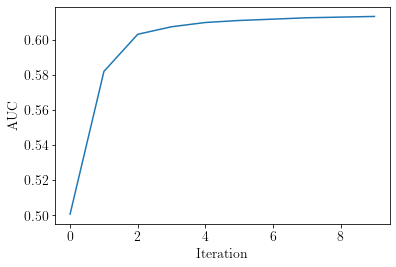

In [10]:
# Train the recommender using SGD
zm, zn, auc = SGD_BI(zm, zn, lamda, 10, 0.1)

plt.figure()
plt.plot(range(len(auc)), auc)
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.savefig('figures/auc.jpg', dpi=300)
plt.show()

In [11]:
# Find a user's top 10 movies
# 43 is a child, 77 is superhero, 600 has monty python, 426 likes harry potter -> now you see me, 543 gets lotr
user = 44
topN = 20

# Find the users top N movies
ratings = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/ratings.csv')
moviedata = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/movies.csv')
users_movies = ratings[ratings['userId'] == user].nlargest(topN, 'rating')

users_movies['movieId'] = users_movies['movieId'].replace(moviedata.set_index('movieId')['title'])
users_movies

,userId,movieId,rating,timestamp
6440,44,Rumble in the Bronx (Hont faan kui) (1995),5.0,869251955
6443,44,Star Wars: Episode IV - A New Hope (1977),5.0,869251910
6451,44,"Rock, The (1996)",5.0,869251910
6453,44,Barb Wire (1996),5.0,869252012
6467,44,Star Wars: Episode VI - Return of the Jedi (1983),5.0,869252333
6471,44,First Strike (Police Story 4: First Strike) (G...,5.0,869252417
6472,44,Private Parts (1997),5.0,869252362
6476,44,Chasing Amy (1997),5.0,895853739
6433,44,Four Rooms (1995),4.0,869252115
6434,44,Dead Man Walking (1995),4.0,869251910


In [14]:
# Find the predicted top N movies the user has seen
unseen = []
for n in range(num_items):
    if n in user_index[user-1][0]:
        # Movie the user has not seen
        r = predict(user-1, n, zm, zn, 0)
        unseen.append({'movieId':n, 'predicted rating':r})

unseenmovies = pd.DataFrame(unseen).nlargest(topN, 'predicted rating')
unseenmovies['movieId'] = unseenmovies['movieId'].map(invmoviemap)
unseenmovies['movieId'] = unseenmovies['movieId'].replace(moviedata.set_index('movieId')['title'])

unseenmovies

,movieId,predicted rating
5,"Rock, The (1996)",9.333888
2,Independence Day (a.k.a. ID4) (1996),9.299683
16,James and the Giant Peach (1996),8.841998
11,Broken Arrow (1996),8.752399
1,Toy Story (1995),8.268136
4,Mission: Impossible (1996),7.936088
0,Star Wars: Episode IV - A New Hope (1977),7.669888
23,Bio-Dome (1996),7.288898
9,"Birdcage, The (1996)",7.221388
22,"Time to Kill, A (1996)",7.087017


In [15]:
# Find the predicted top N movies the user has not seen
unseen = []
for n in range(num_items):
    if n not in user_index[user-1][0]:
        # Movie the user has not seen
        r = predict(user-1, n, zm, zn, 0)
        unseen.append({'movieId':n, 'predicted rating':r})

unseenmovies = pd.DataFrame(unseen).nlargest(topN, 'predicted rating')
unseenmovies['movieId'] = unseenmovies['movieId'].map(invmoviemap)
unseenmovies['movieId'] = unseenmovies['movieId'].replace(moviedata.set_index('movieId')['title'])

unseenmovies

,movieId,predicted rating
75,Twister (1996),9.534743
84,Willy Wonka & the Chocolate Factory (1971),8.473234
185,"Nutty Professor, The (1996)",8.235193
195,Mr. Holland's Opus (1995),8.217558
149,"Wizard of Oz, The (1939)",7.874700
387,Sabrina (1995),7.726548
1499,Sudden Death (1995),7.617634
280,Eraser (1996),7.426927
655,Miracle on 34th Street (1994),7.392231
350,Cool Hand Luke (1967),7.363034


In [12]:
# High-level API
def recommend(userID, versionID, N=20):
    # Recommend N movies for userID in group versionID

    # Step 1: Make predictions for all the movies a user has not seen and rank them
    unseen = []
    for n in range(num_items):
        if n not in user_index[userID - 1][0]:
            r = predict(userID - 1, n, zm, zn, versionID)
            unseen.append({'movieId':n, 'predicted rating':r})

    # Create panda dataframe and rank the movies
    recommendations = pd.DataFrame(unseen).nlargest(N, 'predicted rating')
    recommendations['movieId'] = recommendations['movieId'].map(invmoviemap)

    # Add the natural language movie titles
    recommendations['movieName'] = recommendations['movieId']
    recommendations['movieName'] = recommendations['movieName'].replace(moviedata.set_index('movieId')['title'])
    del recommendations['predicted rating']

    # Return python list
    return recommendations.values.tolist()

In [14]:
# Find a t-sne embedding of the item vectors (excluding the bias of course)
tsne_movies = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=100).fit_transform(zn.T)

In [15]:
# function to find the genres of a specific movie ID
def getGenre(movieId):
    moviedata = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale//ml-latest-small/movies.csv')

    moviess = moviedata
    moviess['movieId'] = moviess['movieId'].map(moviemap)
    x = moviess[moviess['movieId'] == movieId].to_numpy()[0][2].split('|')
    return x

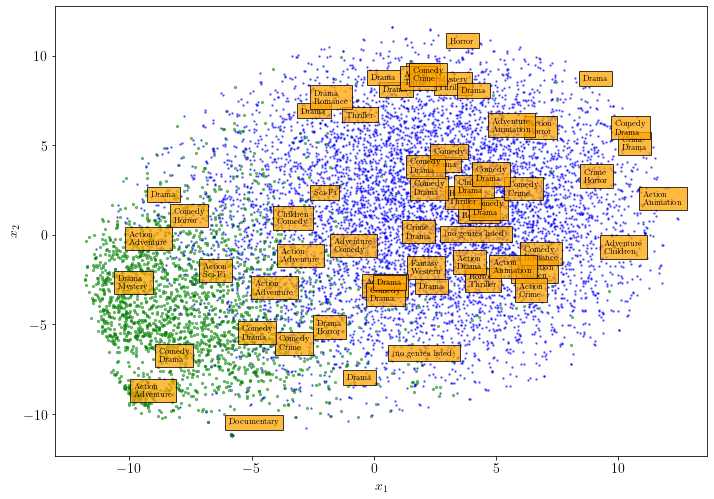

In [18]:
# Plot the 2D dims tsne
fig = plt.figure()
for x in range(num_items):
    if(x < 2300): # 80% of the ratings change the number still. pareto principle
        c = 'green' 
        dot = 5
    else:
        c = 'blue' # rest
        dot = 2

    plt.scatter(tsne_movies.T[0, x], tsne_movies.T[1, x], s=dot, color=c, alpha=0.5)

have = []
for x in range(60):

    y = np.random.choice(np.arange(num_items))
    genres = getGenre(y)
    if(len(genres) > 2): genres = genres[:2]
    g = '\n'.join(genres)
    plt.text(tsne_movies.T[0, y], tsne_movies.T[1, y], g, fontsize=8, usetex=True, bbox=dict(facecolor='orange', alpha=0.75))


plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$") 
fig.set_size_inches(11.69, 8.27)
plt.savefig("figures/2D_BIF_movies_tsne.jpg", dpi=300)
plt.show()
